In [11]:
import cv2
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [32]:
def get_slice_no(raw_path):
    l3_dcm_id = None
    with open(raw_path, 'r', encoding="utf-8") as f:
        lines = f.readlines()
    for i, line in enumerate(lines):
        if line.strip() == "#SliceNo":
            l3_dcm_id = int(lines[i+1])
            return l3_dcm_id
    return l3_dcm_id


def get_testset_files():
    raw_data_home = r'C:\Users\qwe14\0.code\sarcopenia\data_train_raw\#AsanNas'
    test_mask_home = r"C:\Users\qwe14\0.code\sarcopenia\data_test\masks"
    with open("data_relation.txt", "r", encoding='utf-8') as f:
        lines = f.readlines()

    test_set_list = []
    for line in lines:
        try:
            dcm_parent, mask_file = line.strip().split("\t") #SarcopeniaCase1/20061220_DCM	00001_20061220.png
            dcm_raw_file = dcm_parent.replace("DCM", "RAW.txt")
            dcm_raw_path = f"{raw_data_home}\\{dcm_raw_file}"
            dcm_num = get_slice_no(dcm_raw_path)
            dcm_file = f"{dcm_num:05d}.dcm"
            dcm_path = f"{raw_data_home}\\{dcm_parent}\\{dcm_file}"
            mask_path = f"{test_mask_home}\\{mask_file}"
            temp = [dcm_path, mask_path]
            test_set_list.append(temp)
        except FileNotFoundError as e:
            pass
    return test_set_list

In [33]:
test_set = get_testset_files()

In [34]:
print(len(test_set))

901


In [87]:
def norm_img(img):
    norm_image = np.array(img, dtype=np.float64)
    norm_image -= np.min(norm_image)
    norm_image /= np.max(norm_image)
    normalized_image = norm_image * 255
    normalized_image = normalized_image.astype(np.uint8)
    return normalized_image


def get_preprocess_dcm_img(dcm):
    dcm_array = dcm.pixel_array
    try:
        hu_image = dcm_array * dcm.RescaleSlope + dcm.RescaleIntercept
        img_min = dcm.WindowCenter - dcm.WindowWidth // 2
        img_max = dcm.WindowCenter + dcm.WindowWidth // 2
    except AttributeError:
        hu_image = dcm_array
        img_min = 40 - 200
        img_max = 40 + 200
    except TypeError:
        img_min = dcm.WindowCenter[0] - dcm.WindowWidth[0] // 2
        img_max = dcm.WindowCenter[0] + dcm.WindowWidth[0] // 2
    hu_image[hu_image < -1024] = np.array(-1024).astype(hu_image.dtype)
    preprocessed_img = np.clip(hu_image, img_min, img_max)
    return preprocessed_img


def fat_on_png_v3(dcm_path, mask_path, save_path, resize_scale):
    output_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    color_mapping = {
        3: [[-190, -30], [0x2A, 0x1E, 0x42]],  # RGB color for mask == 3 (내장지방, 보라) Vfat(-190~-30)visceral fat
        2: [[-190, 150], [0x9F, 0x57, 0x5A]],  # RGB color for mask == 2 (Muscle, 분홍) Muscle(-190~150)
        1: [[-190, -30], [0x3B, 0x1B, 0x16]],  # RGB color for mask == 1 (Fat, 갈색) Sfat(-190~-30)subcutaneous fat
        4: [[-29, 29], [0x35, 0x89, 0x81]],     # (LAMA, 탁한노랑) LAMA(-29~29)
        5: [[30, 150], [0x94, 0x92, 0x54]],     # (NAMA, 청록) NAMA(30~150)
    }
    dcm = pydicom.dcmread(dcm_path)
    hu_image = get_preprocessed_dcm_img(dcm)

    # Vfat mask postprocess
    Vfat_range = color_mapping[1][0]
    Vfat_condition1 = (Vfat_range[0] < hu_image)
    Vfat_condition2 = (hu_image < Vfat_range[1])
    co = Vfat_condition1 & Vfat_condition2
    vfat_mask = np.zeros_like(output_mask)
    print(mask_path)
    print(f"output_mask: {output_mask.shape}")
    vfat_mask[co.astype(bool) & (output_mask == 1)] = 1
    output_mask[(vfat_mask != 1) & (output_mask == 1)] = 0

    # muscle mask postprocess for LAMA mask
    lama_range = color_mapping[4][0]
    lama_condition1 = (lama_range[0] <= hu_image)
    lama_condition2 = (hu_image <= lama_range[1])
    co = lama_condition1 & lama_condition2
    lama_mask = np.zeros_like(output_mask)
    lama_mask[co.astype(bool) & (output_mask == 2)] = 1
    output_mask[lama_mask] = 4

    # muscle mask postprocess for NAMA mask
    nama_range = color_mapping[5][0]
    nama_condition1 = (nama_range[0] <= hu_image)
    nama_condition2 = (hu_image <= nama_range[1])
    co = nama_condition1 & nama_condition2
    nama_mask = np.zeros_like(output_mask)
    nama_mask[co.astype(bool) & (output_mask == 2)] = 1
    output_mask[nama_mask] = 5

    mask_color_map = cv2.cvtColor(output_mask, cv2.COLOR_GRAY2BGR)
    for key, values in color_mapping.items():
        color = values[1]
        mask_color_map[output_mask == key] = color
        if (output_mask == key).sum():
            print(key, color, (output_mask == key).sum())
    # plt.figure(figsize=(f_size//2,f_size//2))
    # plt.imshow(cv2.cvtColor(mask_color_map, cv2.COLOR_BGR2RGB))  # Convert to RGB for matplotlib
    # plt.show()

    background_img = get_preprocess_dcm_img(dcm)
    preprocessed_img = norm_img(background_img)
    preprocessed_img = cv2.cvtColor(preprocessed_img, cv2.COLOR_GRAY2BGR)
    # overlay_image = preprocessed_img
    # overlay_image = overlay_image.astype(np.uint8)
    # overlay_image = cv2.addWeighted(mask_color_map, 0.8, preprocessed_img, 0.6, 0)

    overlay_image = preprocessed_img
    overlay_image[output_mask != 0] = mask_color_map[output_mask != 0]

    # plt.figure(figsize=(f_size//2,f_size//2))
    # plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))  # Convert to RGB for matplotlib
    # plt.show()
    
    # Resize the resulting image
    resized_image = cv2.resize(overlay_image, (resize_scale, resize_scale), interpolation=cv2.INTER_LINEAR)
    
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.gca().set_title('Quality map')
    plt.imshow(resized_image, cmap = cm.gray) # Mask_Body # 1 이상
    
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.gca().set_title('Mask')
    # mask[mask == 1] = 255//3
    # mask[mask == 2] = 255*2//3
    # mask[mask == 3] = 255
    plt.imshow(output_mask, cmap = cm.gray)  # Mask_SFatIns  # 1, 2
    plt.show()
    # cv2.imwrite(save_path, resized_image)

In [88]:
def post_windowing(test_set):
    for idx, (dcm_path, mask_path) in enumerate(test_set):
        rst_size = 512
        save_path = "temp"
        fat_on_png_v3(dcm_path, mask_path, save_path, rst_size)
        if idx % 300 == 0:
            break

C:\Users\qwe14\0.code\sarcopenia\data_test\masks\00001_20061220.png
output_mask: (512, 512)
3 [42, 30, 66] 19771
2 [159, 87, 90] 17690
1 [59, 27, 22] 18721
5 [84, 146, 148] 1024


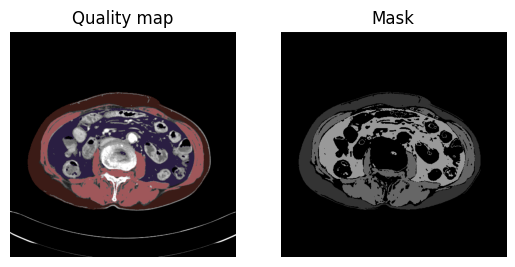

In [89]:
post_windowing(test_set)

### 할 것
1. 이미지, GT, hu 적용된 pred 보여주기
2. iou, acc 등 계산하기
3. 

### IoU, accuracy 계산

In [79]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
def calculate_binary_metrics(pm_mask, gm_mask):
    f1_micro = f1_score(pm_mask.flatten(), gm_mask.flatten(), average='micro')
    f1_macro = f1_score(pm_mask.flatten(), gm_mask.flatten(), average='macro')
    accuracy = accuracy_score(pm_mask.flatten(), gm_mask.flatten())

    return f1_micro, f1_macro, accuracy
    
def calculate_iou(predicted_mask, ground_truth_mask):
    intersection = np.logical_and(predicted_mask, ground_truth_mask)
    union = np.logical_or(predicted_mask, ground_truth_mask)
    
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [ ]:
# idx = 0
# iou_list = []
# acc_list = []
# f1_macro_list = []
# f1_micro_list = []
# for pmp, gmp in zip(pred_mask_paths, gt_mask_paths):
#     idx+=1
#     pm_mask = cv2.imread(pmp, cv2.IMREAD_GRAYSCALE)
#     gm_mask = cv2.imread(gmp, cv2.IMREAD_GRAYSCALE)
#     iou_list.append(calculate_iou(pm_mask, gm_mask))
#     f1_micro, f1_macro, acc = calculate_binary_metrics(pm_mask, gm_mask)
#     acc_list.append(acc)
#     f1_micro_list.append(f1_micro)
#     f1_macro_list.append(f1_macro)

In [ ]:
# print(f"IoU: {np.mean(iou_list)}")
# print(f"f1_macro score: {np.mean(f1_macro_list)}")
# print(f"f1_micro score: {np.mean(f1_micro_list)}")
# print(f"accuacy: {np.mean(acc_list)}")